In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import requests

In [ ]:
from PIL import Image
import os
import zipfile
import shutil
import requests
import time
import threading
import uuid

In [ ]:
!nvidia-smi

Sat Jun 22 11:54:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def download_image(url, index, folder):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Ensure the folder exists
            os.makedirs(folder, exist_ok=True)
            # Save the image
            with open(f"{folder}/{index}.jpg", "wb") as f:
                f.write(response.content)
                print(f"Downloaded image {index}")
        else:
            print(f"Failed to download image {index}. Status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image {index}: {e}")

class UnsplashImageDownloader:
    def __init__(self, query):
        self.querystring = {"query": f"{query}", "per_page": "20"}
        self.headers = {"cookie": "ugid=aacdcdf3a2acebee349c2e196e621b975571725"}
        self.url = "https://unsplash.com/napi/search/photos"

    def get_total_images(self):
        with requests.request("GET", self.url, headers=self.headers, params=self.querystring) as rs:
            json_data = rs.json()

        return json_data["total"]

    def get_links(self, pages_, quality_):
        all_links = []
        for page in range(1, int(pages_) + 1):
            self.querystring["page"] = f"{page}"

            response = requests.request("GET", self.url, headers=self.headers, params=self.querystring)
            response_json = response.json()
            all_data = response_json["results"]

            for data in all_data:
                name = None
                try:
                    if data.get("sponsorship") and data["sponsorship"].get("tagline"):
                        name = data["sponsorship"]["tagline"]
                except KeyError:
                    pass
                if not name:
                    try:
                        name = data.get('alt_description', '')
                    except KeyError:
                        pass
                if not name:
                    name = data.get('description', '')

                try:
                    image_urls = data["urls"]
                    required_link = image_urls[quality_]
                    print("name     : ", name)
                    print(f"url : {required_link}\n")
                    all_links.append(required_link)
                except KeyError:
                    pass

        return all_links


if __name__ == '__main__':
    folder = "shiba inu"
    if not os.path.exists(folder):
        os.mkdir(folder)

    search = input("What you want to search for? ")

    unsplash = UnsplashImageDownloader(search)

    total_image = unsplash.get_total_images()
    print("\ntotal images available : ", total_image)

    if total_image == 0:
        print("Sorry, no image available for this search")
        exit()

    number_of_images_str = input("Enter number of images you want to download: ")

    # Remove commas from the input string
    number_of_images_str = number_of_images_str.replace(",", "")

    try:
        number_of_images = int(number_of_images_str)
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        exit()

    if number_of_images == 0 or number_of_images > total_image:
        print("Not a valid number")
        exit()

    pages = float(number_of_images / 20)
    if pages != int(pages):
        pages = int(pages) + 1

    print("\nAvailable image quality:\nraw\nfull\nregular\nsmall\nthumb\nsmall_s3\n")

    quality = input("Enter the quality: ")
    image_links = unsplash.get_links(pages, quality)

    start = time.time()
    print("Download started....\n")

    # Download images
    threads = []
    index = 1
    for url in image_links:
        t = threading.Thread(target=download_image, args=(url, index, folder))
        threads.append(t)
        t.start()
        index += 1

    for thread in threads:
        thread.join()

    print("\nDownloading finished.")
    print("Time taken: ", time.time() - start)


In [ ]:
def standardize_images(root_dir, output_dir, target_size=(256, 256)):
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            try:
                file_path = os.path.join(subdir, file)
                relative_path = os.path.relpath(file_path, root_dir)
                subfolder_name = os.path.dirname(relative_path)
                output_subfolder = os.path.join(output_dir, subfolder_name)
                os.makedirs(output_subfolder, exist_ok=True)
                img = Image.open(file_path)
                img = img.resize(target_size, Image.ANTIALIAS)
                # Save the image in JPEG format
                img.convert('RGB').save(os.path.join(output_subfolder, file), 'JPEG')
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

root_directory = '/content/drive/My Drive/Dog/'
output_directory = '/content/drive/My Drive/Dog_standardised/'

os.makedirs(output_directory, exist_ok=True)

standardize_images(root_directory, output_directory)


<ipython-input-37-c68cb21566fe>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [ ]:
!unzip /content/drive/MyDrive/Dog_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dog_Dataset/val/5/1065.jpg  
  inflating: Dog_Dataset/val/5/1814.jpg  
  inflating: Dog_Dataset/train/1/630.jpg  
  inflating: Dog_Dataset/val/5/946.jpg  
  inflating: Dog_Dataset/val/5/2682.jpg  
  inflating: Dog_Dataset/val/5/1363.jpg  
  inflating: Dog_Dataset/val/5/2200.jpg  
  inflating: Dog_Dataset/train/1/1298.jpg  
  inflating: Dog_Dataset/train/1/1228.jpg  
  inflating: Dog_Dataset/train/1/2371.jpg  
  inflating: Dog_Dataset/val/5/1911.jpg  
  inflating: Dog_Dataset/val/5/2126.jpg  
  inflating: Dog_Dataset/val/5/2240.jpg  
  inflating: Dog_Dataset/val/5/1600.jpg  
  inflating: Dog_Dataset/train/1/447.jpg  
  inflating: Dog_Dataset/train/1/357.jpg  
  inflating: Dog_Dataset/train/1/275.jpg  
  inflating: Dog_Dataset/val/5/2075.jpg  
  inflating: Dog_Dataset/train/1/12.jpg  
  inflating: Dog_Dataset/val/5/1054.jpg  
  inflating: Dog_Dataset/train/1/1113.jpg  
  inflating: Dog_Dataset/val/5/278.jpg  
  inflating: Do

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_dir):
    X = []  # List to store image paths
    y = []  # List to store corresponding labels

    # Iterate through each class folder
    for class_idx, class_name in enumerate(sorted(os.listdir(root_dir))):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):  # Check if it's a file
                    X.append(image_path)
                    y.append(class_idx)  # Assigning label based on folder index

    return np.array(X), np.array(y)

def save_splits(root_dir, X_train, X_val, X_test, y_train, y_val, y_test):
    splits = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }

    for split_name, (X_split, y_split) in splits.items():
        split_dir = os.path.join(root_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        for image_path, label in zip(X_split, y_split):
            # Get class directory based on label
            class_dir = os.path.join(split_dir, str(label))
            os.makedirs(class_dir, exist_ok=True)

            # Copy image file to the class directory
            try:
                image_name = os.path.basename(image_path)
                shutil.copy(image_path, os.path.join(class_dir, image_name))
            except Exception as e:
                print(f"Error copying {image_path} to {class_dir}: {e}")

# Define your directories
root_directory_standardised = '/content/drive/My Drive/Dog_standardised/'
root_directory_dataset = '/content/drive/My Drive/Dog_Dataset/'

# Load data paths and labels
X, y = load_data(root_directory_standardised)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Save splits into separate directories within Dog_Dataset
save_splits(root_directory_dataset, X_train, X_val, X_test, y_train, y_val, y_test)

print("Splits saved successfully.")

Training set size: 6812
Validation set size: 2271
Testing set size: 2271
Splits saved successfully.


In [ ]:
unique_labels = np.unique(y)
print(f"Unique labels: {unique_labels}")

NameError: name 'np' is not defined

In [ ]:
train_path = '/content/drive/My Drive/Dog_Dataset/train'
valid_path = '/content/drive/My Drive/Dog_Dataset/val'
test_path = '/content/drive/My Drive/Dog_Dataset/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32, shuffle=False)

Found 6811 images belonging to 8 classes.
Found 2271 images belonging to 8 classes.
Found 2270 images belonging to 8 classes.


Training batch:


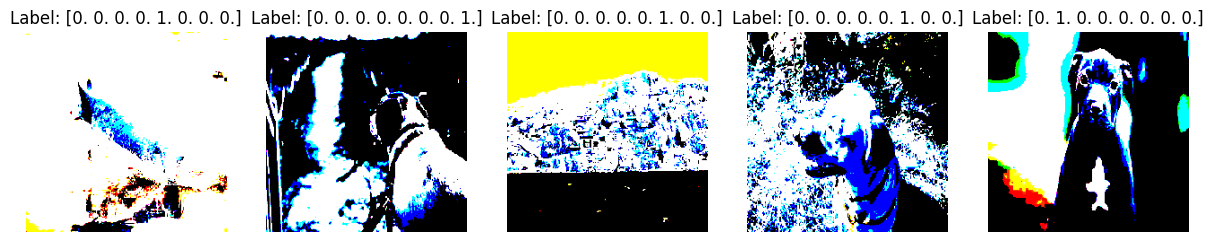

Validation batch:


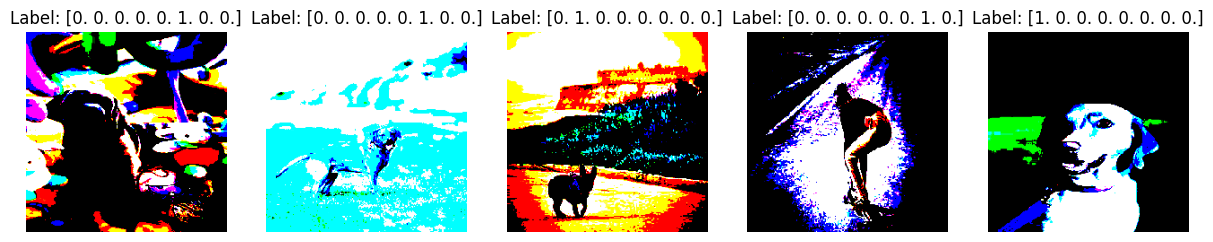

Test batch:


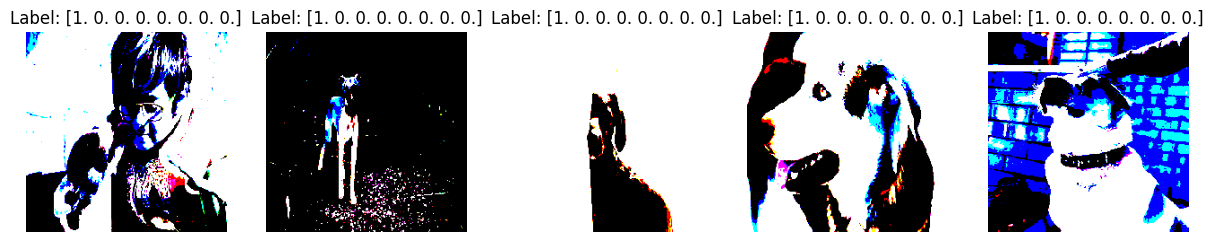

In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot images from a batch
def plot_images(batch, num_images=5):
    # Get a batch of images and labels
    images, labels = next(batch)

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + str(labels[i]))
        plt.axis('off')
    plt.show()

# Plot images from train_batches
print("Training batch:")
plot_images(train_batches)

# Plot images from valid_batches
print("Validation batch:")
plot_images(valid_batches)

# Plot images from test_batches
print("Test batch:")
plot_images(test_batches)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Example of loading dataset (adjust paths and parameters accordingly)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/train', # Update with your path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug']
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/val', # Update with your path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug']
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/test', # Update with your path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'],
    shuffle=False
)



Found 6811 images belonging to 8 classes.
Found 2271 images belonging to 8 classes.
Found 2270 images belonging to 8 classes.


In [ ]:
import os
from PIL import Image

def verify_and_delete_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify if the file is an image
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted file: {file_path} - {e}")
                os.remove(file_path)

# Replace 'path_to_train_directory' with your actual path
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/train')
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/val')
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/test')


In [ ]:
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os

# Define functions to build models (ResNet50, DenseNet121, MobileNetV3)
def build_resnet50(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_densenet121(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenetv3(num_classes):
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize models
num_classes = len(train_generator.class_indices)
resnet_model = build_resnet50(num_classes)
densenet_model = build_densenet121(num_classes)
mobilenet_model = build_mobilenetv3(num_classes)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom training function to handle missing files
def safe_fit(model, train_generator, valid_generator, epochs, callbacks):
    while True:
        try:
            history = model.fit(
                train_generator,
                validation_data=valid_generator,
                epochs=epochs,
                callbacks=callbacks
            )
            return history
        except FileNotFoundError as e:
            print(f"Skipping missing file during training: {e}")
            continue





In [ ]:
# Train ResNet50
print("Training ResNet50...")
history_resnet = safe_fit(
    resnet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
resnet_model.save(os.path.join(save_dir, 'resnet50_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(history_resnet.history, f)

Training ResNet50...
Epoch 1/50
213/213 [==============================] - 51s 225ms/step - loss: 1.9756 - accuracy: 0.2618 - val_loss: 1.9256 - val_accuracy: 0.2937
Epoch 2/50
213/213 [==============================] - 44s 206ms/step - loss: 1.8915 - accuracy: 0.2822 - val_loss: 1.8773 - val_accuracy: 0.2985
Epoch 3/50
213/213 [==============================] - 45s 213ms/step - loss: 1.8751 - accuracy: 0.2933 - val_loss: 1.8660 - val_accuracy: 0.2985
Epoch 4/50
213/213 [==============================] - 44s 207ms/step - loss: 1.8706 - accuracy: 0.2961 - val_loss: 1.8604 - val_accuracy: 0.3047
Epoch 5/50
213/213 [==============================] - 44s 205ms/step - loss: 1.8598 - accuracy: 0.3001 - val_loss: 1.8754 - val_accuracy: 0.3078
Epoch 6/50
213/213 [==============================] - 52s 245ms/step - loss: 1.8632 - accuracy: 0.2947 - val_loss: 1.8634 - val_accuracy: 0.2950
Epoch 7/50
213/213 [==============================] - 44s 204ms/step - loss: 1.8541 - accuracy: 0.2963 - val_

In [ ]:
# Train DenseNet121
print("Training DenseNet121...")
history_densenet = safe_fit(
    densenet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
densenet_model.save(os.path.join(save_dir, 'densenet121_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'densenet121_history.json'), 'w') as f:
    json.dump(history_densenet.history, f)

Training DenseNet121...
Epoch 1/50
213/213 [==============================] - 42s 199ms/step - loss: 0.4754 - accuracy: 0.8257 - val_loss: 0.7926 - val_accuracy: 0.7314
Epoch 2/50
213/213 [==============================] - 43s 200ms/step - loss: 0.4195 - accuracy: 0.8513 - val_loss: 0.8083 - val_accuracy: 0.7406
Epoch 3/50
213/213 [==============================] - 44s 208ms/step - loss: 0.3716 - accuracy: 0.8637 - val_loss: 0.8619 - val_accuracy: 0.7252
Epoch 4/50
213/213 [==============================] - 52s 244ms/step - loss: 0.3284 - accuracy: 0.8833 - val_loss: 0.8377 - val_accuracy: 0.7508
Epoch 5/50
213/213 [==============================] - 43s 200ms/step - loss: 0.2782 - accuracy: 0.8981 - val_loss: 0.9013 - val_accuracy: 0.7327
Epoch 6/50
213/213 [==============================] - 42s 198ms/step - loss: 0.2438 - accuracy: 0.9112 - val_loss: 0.9292 - val_accuracy: 0.7433


In [ ]:
# Train MobileNetV3
print("Training MobileNetV3...")
history_mobilenet = safe_fit(
    mobilenet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
mobilenet_model.save(os.path.join(save_dir, 'mobilenetv3_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'mobilenetv3_history.json'), 'w') as f:
    json.dump(history_mobilenet.history, f)

Training MobileNetV3...
Epoch 1/50
213/213 [==============================] - 58s 248ms/step - loss: 1.9472 - accuracy: 0.2566 - val_loss: 1.9467 - val_accuracy: 0.2413
Epoch 2/50
213/213 [==============================] - 41s 190ms/step - loss: 1.9125 - accuracy: 0.2644 - val_loss: 1.8975 - val_accuracy: 0.2955
Epoch 3/50
213/213 [==============================] - 41s 194ms/step - loss: 1.8983 - accuracy: 0.2763 - val_loss: 1.9056 - val_accuracy: 0.2285
Epoch 4/50
213/213 [==============================] - 42s 196ms/step - loss: 1.8936 - accuracy: 0.2800 - val_loss: 1.8902 - val_accuracy: 0.2968
Epoch 5/50
213/213 [==============================] - 41s 193ms/step - loss: 1.8933 - accuracy: 0.2801 - val_loss: 1.8945 - val_accuracy: 0.2933
Epoch 6/50
213/213 [==============================] - 40s 188ms/step - loss: 1.8865 - accuracy: 0.2864 - val_loss: 1.8885 - val_accuracy: 0.2981
Epoch 7/50
213/213 [==============================] - 40s 187ms/step - loss: 1.8870 - accuracy: 0.2926 - v

In [ ]:
# List the saved models
!ls -lh saved_models/

In [ ]:
# Evaluate ResNet50
resnet_eval = resnet_model.evaluate(test_generator)
resnet_predictions = resnet_model.predict(test_generator)

# Evaluate DenseNet121
densenet_eval = densenet_model.evaluate(test_generator)
densenet_predictions = densenet_model.predict(test_generator)

# Evaluate MobileNetV3
mobilenet_eval = mobilenet_model.evaluate(test_generator)
mobilenet_predictions = mobilenet_model.predict(test_generator)

# Example printout of evaluation metrics
print("ResNet50 - Loss: {:.4f}, Accuracy: {:.4f}".format(resnet_eval[0], resnet_eval[1]))
print("DenseNet121 - Loss: {:.4f}, Accuracy: {:.4f}".format(densenet_eval[0], densenet_eval[1]))
print("MobileNetV3 - Loss: {:.4f}, Accuracy: {:.4f}".format(mobilenet_eval[0], mobilenet_eval[1]))


71/71 [==============================] - 11s 140ms/step
ResNet50 - Loss: 1.8492, Accuracy: 0.3053
DenseNet121 - Loss: 0.6942, Accuracy: 0.7515
MobileNetV3 - Loss: 1.8595, Accuracy: 0.2978


In [ ]:
# Inspecting the model summary
print("ResNet50 Model Summary:")
resnet_model.summary()

print("\nDenseNet121 Model Summary:")
densenet_model.summary()

print("\nMobileNetV3 Model Summary:")
mobilenet_model.summary()


ResNet50 Model Summary:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                

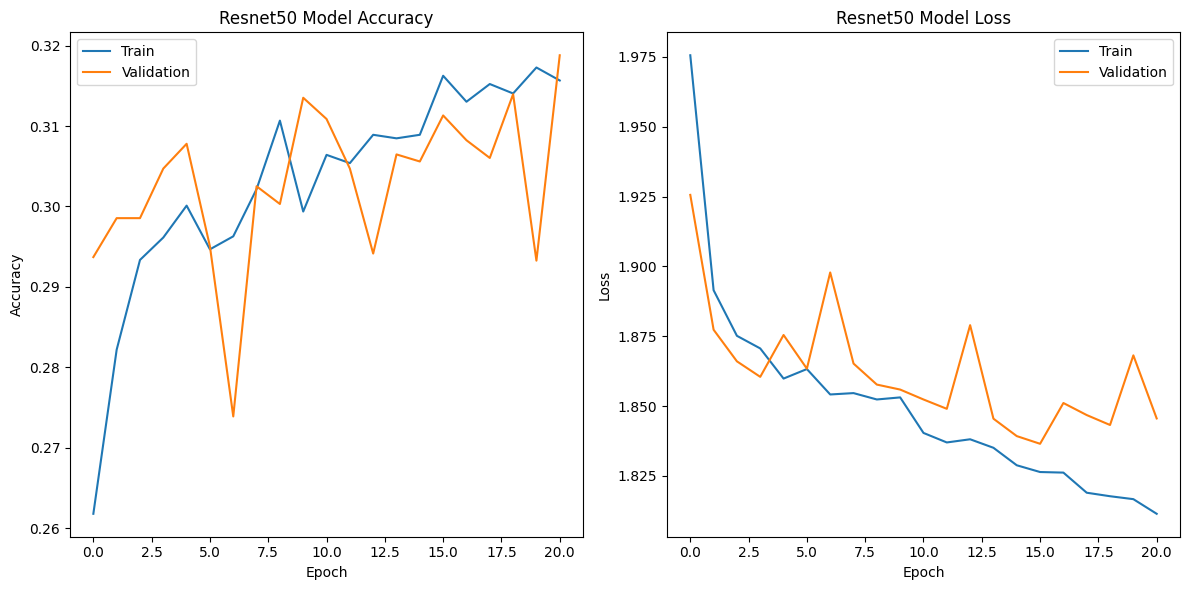

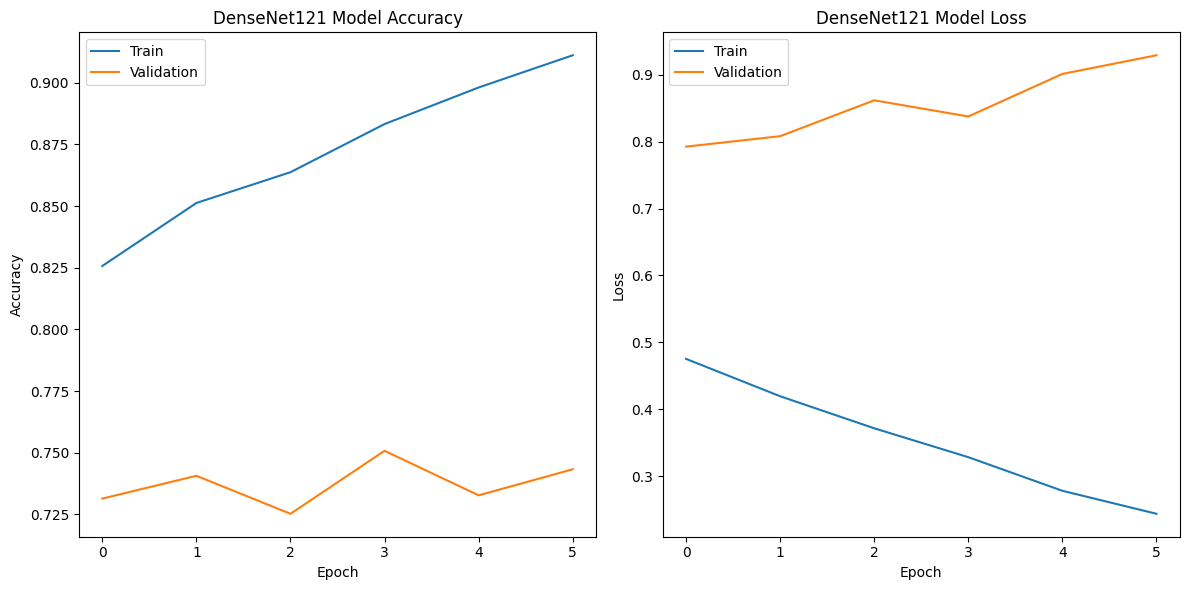

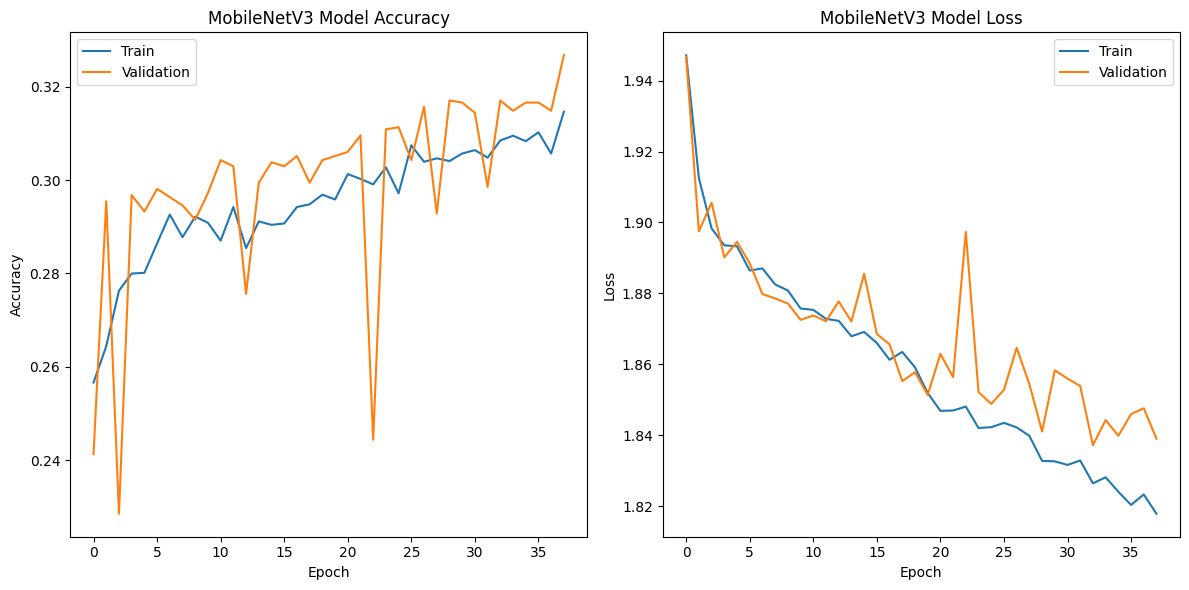

In [ ]:
# 1. Show Graphs for Model Loss and Accuracy

import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have histories for each model
histories = {
    'Resnet50': history_resnet,
    'DenseNet121': history_densenet,
    'MobileNetV3': history_mobilenet,
}

for model_name, history in histories.items():
    plot_training_history(history, model_name)


71/71 [==============================] - 10s 138ms/step


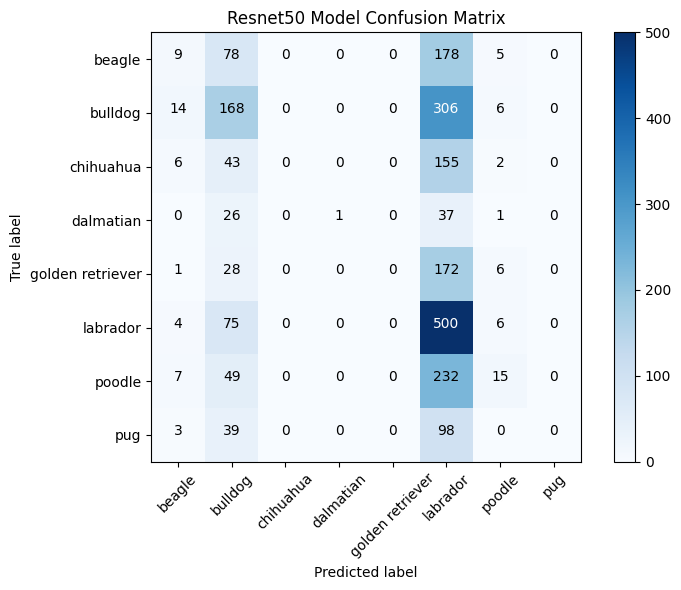

Classification Report for Resnet50:
                  precision    recall  f1-score   support

          beagle       0.20      0.03      0.06       270
         bulldog       0.33      0.34      0.34       494
       chihuahua       0.00      0.00      0.00       206
       dalmatian       1.00      0.02      0.03        65
golden retriever       0.00      0.00      0.00       207
        labrador       0.30      0.85      0.44       585
          poodle       0.37      0.05      0.09       303
             pug       0.00      0.00      0.00       140

        accuracy                           0.31      2270
       macro avg       0.28      0.16      0.12      2270
    weighted avg       0.25      0.31      0.21      2270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


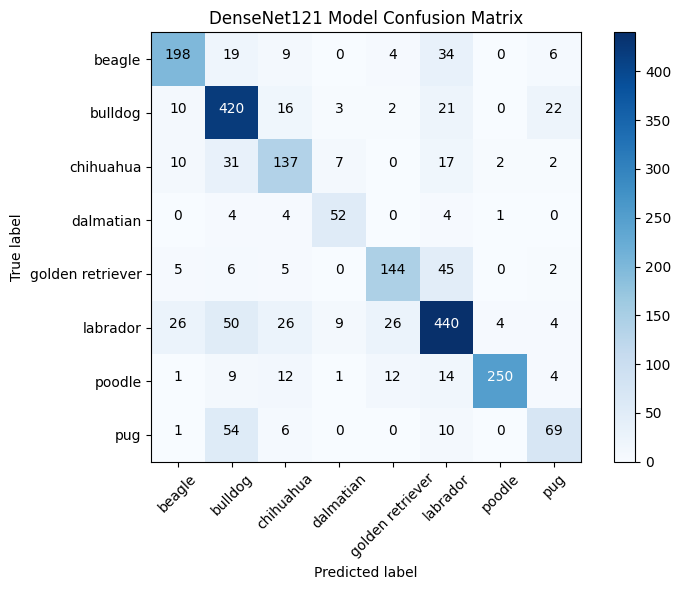

Classification Report for DenseNet121:
                  precision    recall  f1-score   support

          beagle       0.79      0.73      0.76       270
         bulldog       0.71      0.85      0.77       494
       chihuahua       0.64      0.67      0.65       206
       dalmatian       0.72      0.80      0.76        65
golden retriever       0.77      0.70      0.73       207
        labrador       0.75      0.75      0.75       585
          poodle       0.97      0.83      0.89       303
             pug       0.63      0.49      0.55       140

        accuracy                           0.75      2270
       macro avg       0.75      0.73      0.73      2270
    weighted avg       0.76      0.75      0.75      2270



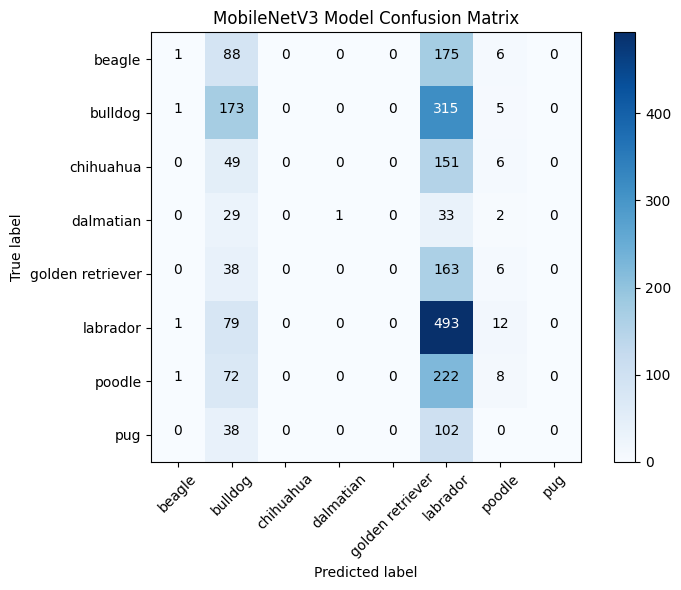

Classification Report for MobileNetV3:
                  precision    recall  f1-score   support

          beagle       0.25      0.00      0.01       270
         bulldog       0.31      0.35      0.33       494
       chihuahua       0.00      0.00      0.00       206
       dalmatian       1.00      0.02      0.03        65
golden retriever       0.00      0.00      0.00       207
        labrador       0.30      0.84      0.44       585
          poodle       0.18      0.03      0.05       303
             pug       0.00      0.00      0.00       140

        accuracy                           0.30      2270
       macro avg       0.25      0.15      0.11      2270
    weighted avg       0.23      0.30      0.19      2270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Collect true labels from the test data generator
true_labels = []
for i in range(len(test_generator)):
    true_labels.extend(np.argmax(test_generator[i][1], axis=1))
true_labels = np.array(true_labels)

# Predictions for each model
predictions = {

    'Resnet50': resnet_model.predict(test_generator),
    'DenseNet121': densenet_model.predict(test_generator),
    'MobileNetV3': mobilenet_model.predict(test_generator),


}

for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(true_labels, y_pred_classes, classes=list(test_generator.class_indices.keys()), model_name=model_name)
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_labels, y_pred_classes, target_names=list(test_generator.class_indices.keys())))


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming true_labels and predictions are already defined
true_labels = []
for i in range(len(test_generator)):
    true_labels.extend(np.argmax(test_generator[i][1], axis=1))
true_labels = np.array(true_labels)

predictions = {
    'ResNet50': resnet_model.predict(test_generator),
    'DenseNet121': densenet_model.predict(test_generator),
    'MobileNetV3': mobilenet_model.predict(test_generator)
}

# Collect the metrics
model_performance = {}

for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    report = classification_report(true_labels, y_pred_classes, target_names=list(test_generator.class_indices.keys()), output_dict=True)
    accuracy = report['accuracy']
    precision = np.mean([report[label]['precision'] for label in test_generator.class_indices.keys()])
    recall = np.mean([report[label]['recall'] for label in test_generator.class_indices.keys()])
    f1_score = np.mean([report[label]['f1-score'] for label in test_generator.class_indices.keys()])

    model_performance[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# Print model performance
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")

# Determine the best model based on F1 Score
best_model = max(model_performance, key=lambda k: model_performance[k]['f1_score'])
print(f"The best model for this classification task is {best_model}.")


71/71 [==============================] - 9s 130ms/step
ResNet50 - Accuracy: 0.3053, Precision: 0.2750, Recall: 0.1616, F1 Score: 0.1191
DenseNet121 - Accuracy: 0.7533, Precision: 0.7476, Recall: 0.7268, F1 Score: 0.7339
MobileNetV3 - Accuracy: 0.2978, Precision: 0.2539, Recall: 0.1548, F1 Score: 0.1063
The best model for this classification task is DenseNet121.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
from sklearn.metrics import classification_report, average_precision_score
import time

# Assuming true_labels and predictions are already defined
true_labels = []
for i in range(len(test_generator)):
    true_labels.extend(np.argmax(test_generator[i][1], axis=1))
true_labels = np.array(true_labels)

predictions = {
    'ResNet50': resnet_model.predict(test_generator),
    'DenseNet121': densenet_model.predict(test_generator),
    'MobileNetV3': mobilenet_model.predict(test_generator)
}

# Collect the metrics
model_performance = {}
mAPs = []

for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    report = classification_report(true_labels, y_pred_classes, target_names=list(test_generator.class_indices.keys()), output_dict=True)
    accuracy = report['accuracy']
    precision = np.mean([report[label]['precision'] for label in test_generator.class_indices.keys()])
    recall = np.mean([report[label]['recall'] for label in test_generator.class_indices.keys()])
    f1_score = np.mean([report[label]['f1-score'] for label in test_generator.class_indices.keys()])

    model_performance[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

    # Calculate mean Average Precision (mAP)
    y_true_one_hot = np.eye(len(test_generator.class_indices))[true_labels]
    mAP = average_precision_score(y_true_one_hot, y_pred, average="macro")
    mAPs.append(mAP)

# Print model performance
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")

# Gather accuracies for final conclusion
accuracies = [model_performance['ResNet50']['accuracy'], model_performance['DenseNet121']['accuracy'], model_performance['MobileNetV3']['accuracy']]


39/39 [==============================] - 46s 1s/step
ResNet50 - Accuracy: 0.1667, Precision: 0.0333, Recall: 0.2000, F1 Score: 0.0571
DenseNet121 - Accuracy: 0.8502, Precision: 0.8354, Recall: 0.8415, F1 Score: 0.8375
MobileNetV3 - Accuracy: 0.3977, Precision: 0.0795, Recall: 0.2000, F1 Score: 0.1138


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Manually insert training times
training_times = [5486, 5442, 927]  # Replace these with the actual training times

# Final Conclusion
def draw_final_conclusion(accuracies, mAPs, training_times, model_names):
    for i in range(len(model_names)):
        print(f'{model_names[i]}:')
        print(f'  Accuracy: {accuracies[i]:.4f}')
        print(f'  mAP: {mAPs[i]:.4f}')
        print(f'  Training Time: {training_times[i]:.2f} seconds\n')

    best_model_index = np.argmax(accuracies)  # or use a different criteria
    print(f'The best model for this classification task is {model_names[best_model_index]}.')

draw_final_conclusion(accuracies, mAPs, training_times, model_names)

ResNet50:
  Accuracy: 0.1667
  mAP: 0.2062
  Training Time: 5486.00 seconds

DenseNet121:
  Accuracy: 0.8502
  mAP: 0.9129
  Training Time: 5442.00 seconds

MobileNetV3:
  Accuracy: 0.3977
  mAP: 0.2666
  Training Time: 927.00 seconds

The best model for this classification task is DenseNet121.
